In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

from tqdm import tqdm
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler

In [2]:
def MAD_winsorize(x, multiplier=5):
    """MAD去除极端值"""
    med = np.nanmedian(x)
    x_MAD = np.nanmedian(np.abs(x - med))
    upper = med + multiplier * x_MAD
    lower = med - multiplier * x_MAD
    x[x > upper] = upper
    x[x < lower] = lower
    return x

def symmetric(matrix):
    """对称正交化"""
    F = np.array(matrix, dtype=np.float64)
    Lambda, Q = np.linalg.eigh(np.dot(F.T, F))
    D = np.diag(Lambda ** (-0.5))
    D = np.where(np.isnan(D), 0, D)
    Fhat = np.dot(F, Q)
    Fhat = np.dot(Fhat, D)
    Fhat = np.dot(Fhat, Q.T)

    return Fhat

def max_drawdown(cml_rets):
    """
    计算投资组合的最大回撤，最大回撤时长
    :param cml_rets: 组合的累计收益
    """
    n = len(cml_rets)
    res = 0
    before = temp = after = 0
    a = cml_rets[0]
    for i in range(1, n):
        b = cml_rets[i]
        if (1 - b / a) > res:
            res = 1 - b / a
            after = i
            before = temp
        if b > a:
            a = b
            temp = i
    return res, after - before

def get_adjust_dt(date_ls, freq):
    """
    根据给定的日期区间和频率获取选股日期，即每月或每周的第一个交易日
    :param date_ls: 一段时间内的所有交易日
    :param freq:    调仓频率
    """
    result = []
    if freq == 'day':
        result = date_ls

    if freq == 'week':
        for i in range(1, len(date_ls)):
            if (dates[i - 1].weekday() >= dates[i].weekday()) or (dates[i] - dates[i - 1] >= timedelta(days=7)):
                result.append(date_ls[i])

    if freq == 'month':
        for i in range(1, len(date_ls)):
            if date_ls[i].month != date_ls[i - 1].month:
                result.append(date_ls[i])

    if result[0] != date_ls[0]:
        result.insert(0, date_ls[0])
    result = [datetime.strftime(date, '%Y%m%d') for date in result]
    return result


def get_choose_dt(date_ls, freq):
    """
    根据给定的日期区间和频率获取选股日期，即每月或每周的最后一个交易日
    :param date_ls: 一段时间内的所有交易日
    :param freq:    调仓频率
    """
    result = []
    if freq == 'day':
        result = date_ls

    if freq == 'week':
        for i in range(len(date_ls) - 1):
            if (dates[i].weekday() >= dates[i + 1].weekday()) or (dates[i + 1] - dates[i] >= timedelta(days=7)):
                result.append(date_ls[i])

    if freq == 'month':
        for i in range(len(date_ls) - 1):
            if date_ls[i].month != date_ls[i + 1].month:
                result.append(date_ls[i])

    if result[-1] != date_ls[-1]:
        result.append(date_ls[-1])
    result = [datetime.strftime(date, '%Y%m%d') for date in result]
    return result

In [3]:
# 读取因子数据
cap = pd.read_parquet('size_nlsize(2010-2023).parquet')
beta = pd.read_parquet('Beta(2010-2023).parquet')
bm = pd.read_parquet('book_to_price(2010-2023).parquet')
momentum = pd.read_parquet('momentum(2010-2023).parquet')

In [4]:
# 读取指数收益率及各股每日收益
names = pd.read_parquet('names(2010-2023).parquet')
hist_ret = pd.read_parquet('hist returns(10-23).parquet')
# 通过pandas合成数据
returns = pd.merge(names, hist_ret, on=['date', 'code'], how='left')
hist_ret = hist_ret.pivot(index='date', columns='code', values='pct_change')

In [5]:
# 去除Nan
factors = pd.merge(cap, beta, on=['date', 'code']).merge(bm, on=['date', 'code'])
df = pd.merge(returns, factors, on=['date', 'code'])
df.dropna(axis=0, inplace=True)

In [6]:
df.head()

,date,code,pct_change,lncap,nlcap,Beta,bp
0,20100104,000001.SZ,-0.027082,15.811976,0.655442,0.928897,0.259249
1,20100104,000002.SZ,-0.019426,16.271239,1.806584,1.030812,0.299814
2,20100104,000005.SZ,-0.004983,13.213457,-0.589400,1.016940,0.135157
3,20100104,000006.SZ,-0.018535,13.242788,-0.621973,1.201801,0.334258
4,20100104,000009.SZ,-0.012750,13.983034,-1.106823,1.075931,0.160154


In [7]:
dates = df.date.unique()
factor_yields = pd.DataFrame(index=dates, columns=factors.columns[2:])
residuals = pd.DataFrame(columns=['date', 'code', 'resid'])

# 每个交易日进行横截面回归求因子收益率
for date in tqdm(dates, desc='Processing'):
    tmp = df[df['date'] == date].copy()
    y = tmp['pct_change'].to_numpy().reshape(-1, 1)
    # 因子去极值， 标准化
    fac_vals = tmp.iloc[:, 3:].apply(MAD_winsorize)
    scaler = StandardScaler()
    X = scaler.fit_transform(fac_vals)
    # 因子正交化
    X = symmetric(X)
    X = sm.add_constant(X)  
    # 使用WLS回归，权重为总市值的平方根
    weights = np.sqrt(np.exp(fac_vals['lncap']))
    w = np.diag(1 / weights) 
    params = np.linalg.pinv(X.T @ w @ X) @ X.T @ w @ y
    resid = y - X @ params
    factor_yields.loc[date] = params[1:].flatten()
    
    res_df = tmp[['date', 'code']].copy()
    res_df['resid'] = resid
    residuals = pd.concat([residuals, res_df], axis=0)

Processing: 100%|██████████| 3401/3401 [49:13<00:00,  1.15it/s]


In [8]:
factor_yields.head()

,lncap,nlcap,Beta,bp
20100104,-0.174852,-0.100703,-0.041817,-0.077348
20100105,-0.04506,-0.011352,0.118523,-0.096765
20100106,0.003165,-0.046371,0.009001,-0.018047
20100107,0.039521,-0.015356,-0.061786,-0.028686
20100108,-0.135442,-0.079532,0.020745,-0.003821


In [9]:
factor_yields.index = pd.to_datetime(factor_yields.index)
factor_yields.to_parquet('factor_returns.parquet')

In [ ]:
# 市值因子统计
legends = [i for i in range(2010, 2024)]
cap_summary = pd.DataFrame(index=legends, columns=['mean', 'volatility', 'year_return', 'sharpe', 'skew', 'kurtosis'])

cap_summary['mean'] = factor_yields['lncap'].resample('Y').mean()
cap_summary['volatility'] = factor_yields['lncap'].resample('Y').std()
cap_summary['skew'] = factor_yields['lncap'].resample('Y').skew()
cap_summary['kurtosis'] = factor_yields['lncap'].resample('Y').kurt()
cap_summary['sharpe'] = cap_summary.mean / cap_summary.volatility * np.sqrt(252)
cap_summary['year_return'] = factor_yields['lncap'].resample('Y').prod()
print(cap_summary)

In [20]:
factors = momentum.copy()
factor_df = factors.pivot(index='date', columns='code', values='rstr')

In [21]:
residuals = residuals.pivot(index='date', columns='code', values='resid')

In [22]:
trade_dt = factors.date.unique()
dates = pd.to_datetime(trade_dt)
# 获取选股日期
adj_dt = get_adjust_dt(dates, 'month')
cho_dt = get_choose_dt(dates, 'month')

In [23]:
# 残差收益率关于动量因子分层
labels = [i for i in range(1, 6)] + ['long_short']
# 按因子大小的组别和日期储存结果
result_mean = pd.DataFrame(1, index=labels, columns=[cho_dt[0]])

n = len(adj_dt)
# 每次获得一期的累计收益，与上期末累计收益相乘
for i in tqdm(range(n - 1), desc="Processing"):
    start1, end1 = adj_dt[i], cho_dt[i]
    start2, end2 = adj_dt[i + 1], cho_dt[i + 1]
    codes = df[df.date == end1].code 
    fac_df = factor_df.loc[start1:end1, codes] 
    rets = residuals.loc[start2:end2, codes]  
    cml = (1 + rets).cumprod().T - 1
    cml['fac'] = fac_df.mean()
    
    cml['group'] = pd.qcut(cml['fac'], q=5, labels=range(1, 6))
    tmp = cml.groupby('group').mean().iloc[:, :-1]
    tmp = pd.DataFrame(tmp, index=range(1, 6))
    tmp.loc['long_short'] = tmp.loc[1] - tmp.loc[5]
    result_mean = pd.concat([result_mean, (1 + tmp).apply(lambda x: x * result_mean.iloc[:, -1])], axis=1)

Processing: 100%|██████████| 142/142 [01:21<00:00,  1.75it/s]


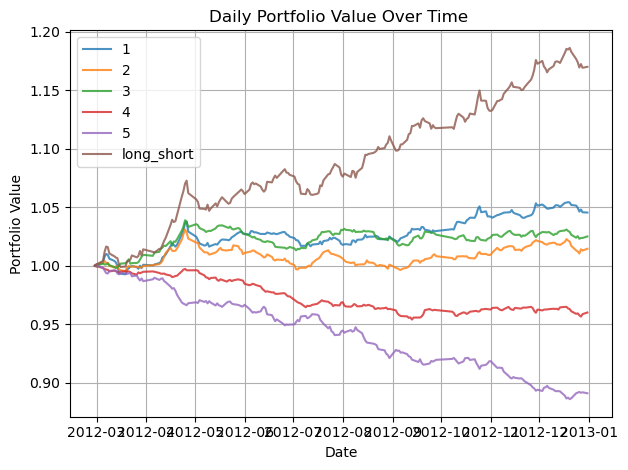

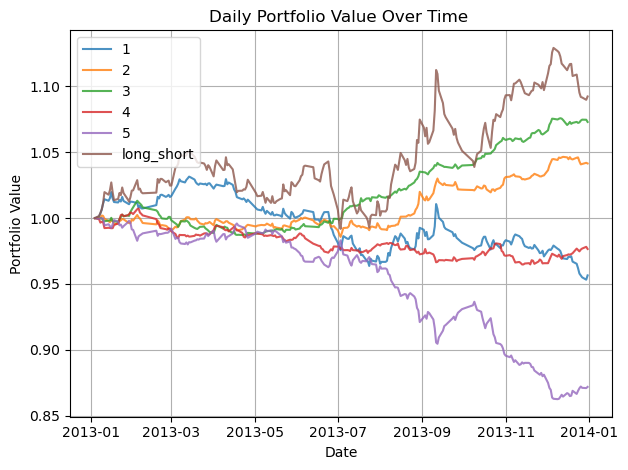

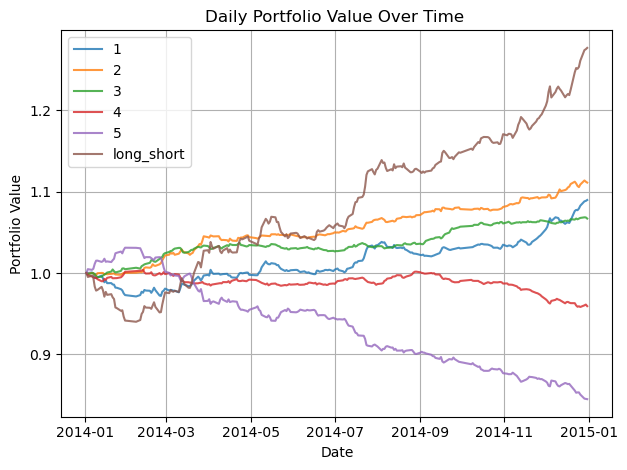

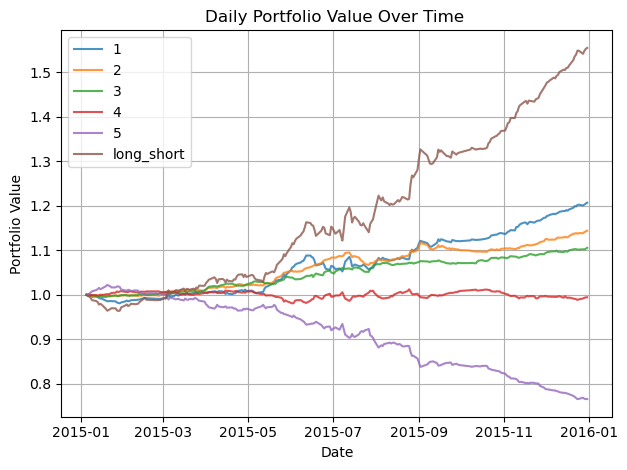

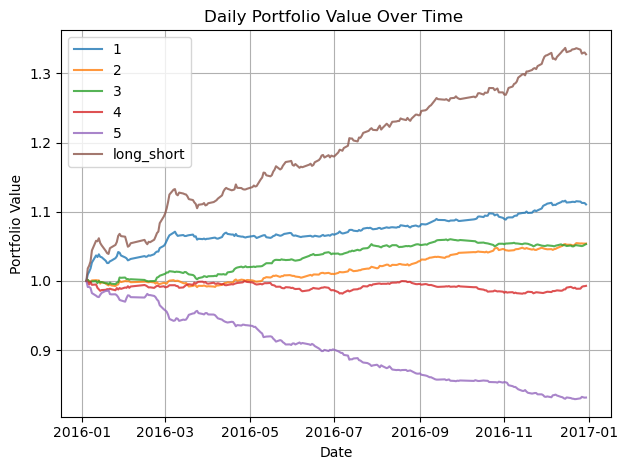

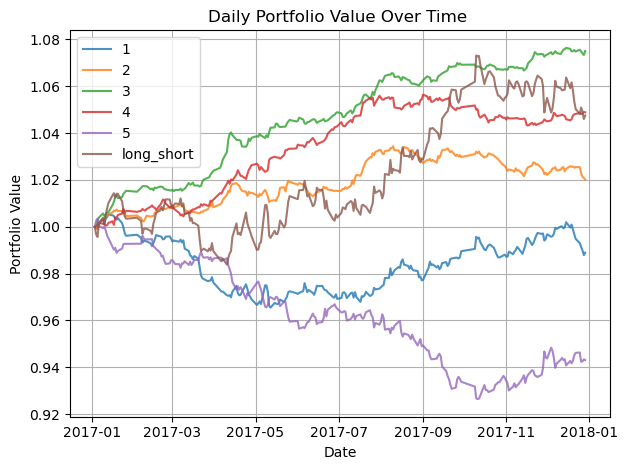

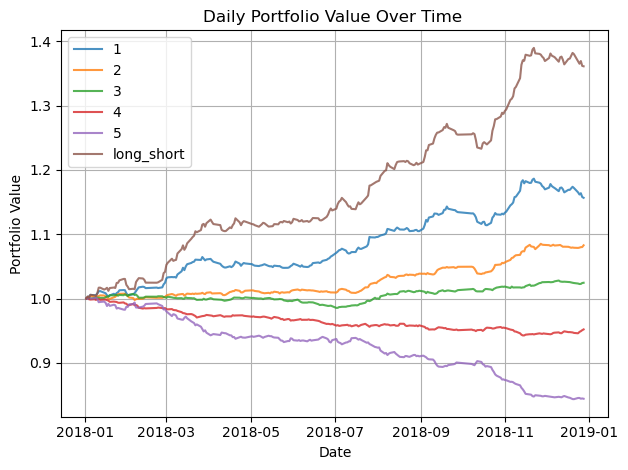

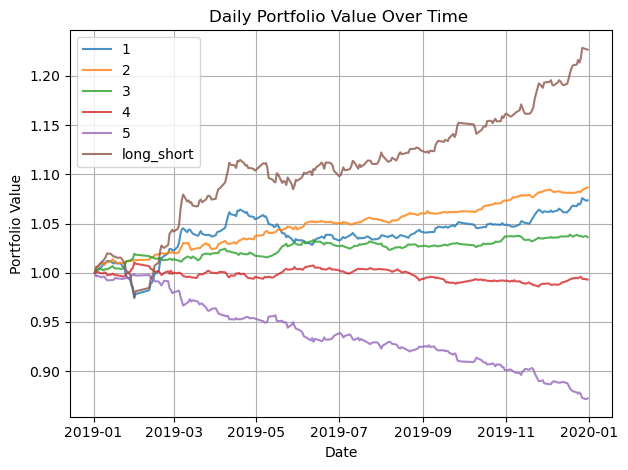

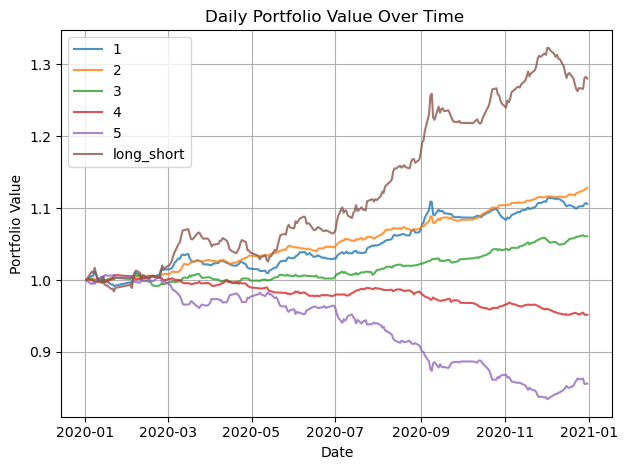

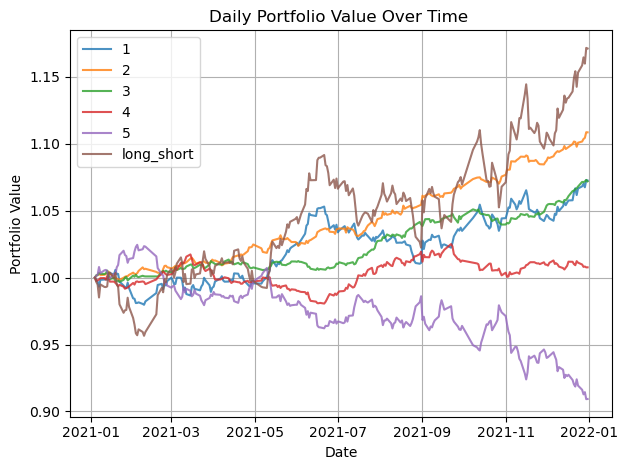

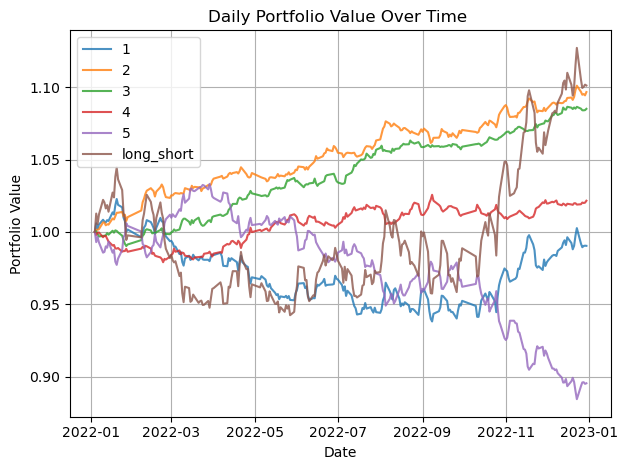

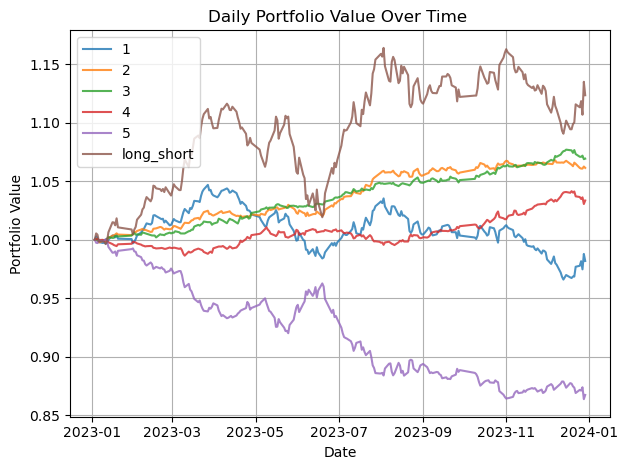

In [24]:
result_mean.columns = pd.to_datetime(result_mean.columns)
years = range(2012, 2024)
for year in years:
    df_year = result_mean.loc[:, result_mean.columns.year == year]
    df_year = df_year.div(df_year.iloc[:, 0], axis=0)
    for i in range(0, 5):
        plt.plot(df_year.iloc[i, :], linewidth=1.5, alpha=0.8, label=str(i + 1))
    plt.plot(df_year.iloc[-1, :], linewidth=1.5, alpha=0.8, label='long_short')


    plt.title('Daily Portfolio Value Over Time ')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value')
    plt.grid(True)
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

In [25]:
legends = [i for i in range(1, 6)] + ['long_short']
daily_return = (result_mean / result_mean.shift(1, axis=1) - 1).dropna(axis=1)
summary = pd.DataFrame(0, index=legends, columns=['return', 'volatility', 'sharpe', 'drawdown', 'drawdown_time'])
summary['return'] = result_mean.iloc[:, -1] - 1
summary['volatility'] = daily_return.std(axis=1)
summary['sharpe'] = daily_return.mean(axis=1) / daily_return.std(axis=1) * np.sqrt(252)
summary[['drawdown', 'drawdown_time']] = np.array(result_mean.apply(max_drawdown, axis=1).tolist()).reshape(6, 2)
print(summary)

               return  volatility    sharpe  drawdown  drawdown_time
1            1.097611    0.002908  1.428070  0.101620          215.0
2            1.485596    0.001571  3.208928  0.033601           93.0
3            1.069292    0.001358  2.963945  0.026615          243.0
4           -0.105171    0.001527 -0.389003  0.177625         2263.0
5           -0.828187    0.003106 -3.101190  0.828907         2877.0
long_short  10.304240    0.005512  2.470577  0.097709           81.0


In [ ]:
years = range(2012, 2024)
for year in years:
    df_year = result_mean.loc[:, result_mean.columns.year == year]
    df_year = df_year.div(df_year.iloc[:, 0], axis=0)
    
    legends = [i for i in range(1, 6)] + ['long_short']
    daily_return = (df_year / df_year.shift(1, axis=1) - 1).dropna(axis=1)
    summary = pd.DataFrame(0, index=legends, columns=['return', 'volatility', 'sharpe', 'drawdown', 'drawdown_time'])
    summary['return'] = df_year.iloc[:, -1] - 1
    summary['volatility'] = daily_return.std(axis=1)
    summary['sharpe'] = daily_return.mean(axis=1) / daily_return.std(axis=1) * np.sqrt(252)
    summary[['drawdown', 'drawdown_time']] = np.array(df_year.apply(max_drawdown, axis=1).tolist()).reshape(6, 2)
    print(year)
    print(summary)